Our  dataset is the  California Housing Prices dataset  the StatLib repository. The version  we used is taken 
the  Kaggle website: https://www.kaggle.com/camnugent/california-housing-prices

The dataset is based on data from the 1990 California census. The census is conducted on several blocks. A block is
the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

The columns describing the  dataset are as follows:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea


We are going to  use the  longitude and latitude to describe  a block (neighborhood), and  determine the  top 100 venues  in the block using Foursquare location. We  will rely on the  top 5 common venues and the  other features of the  datasets to determine a clustering  of the  city. 

Below we give an overview of the dataset. 

In [1]:
#import  all libraries needed
import os
import  numpy as np
import  pandas as pd
from pandas import DataFrame
import scipy
import folium
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize

In [2]:
#Load  data
path="C:\\Users\\makou\\MachineLearning\\housing.csv"

data=pd.read_csv(path)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The  median income  has been scaled and capped between 0.5 and 15.0 The  median age and the  median house value are also capped. Note that as we are interested in clustering, capping and scaling will not influence the results. 

In [3]:
data.shape

(20640, 10)

 The  variable  ocean_proximity determined the  proximity of a neighborhood with respect to the  ocean and bay. It is a categorical variable with five values.

In [4]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The  longitude and  latitude were recorded to two decimal places. Hence several neighborhoods have been given the same geographical coordinates. In the sequel, we are going to group neighborhood by longitude. To the  categorical variable ocean_proximity, we will use the  mode. 

In [6]:
data_group_long=data.groupby(data['longitude'],as_index=False).mean()
e=[]    #this is a list to collect the  entry of the  categorical variable  ocean_proximity
for  z in  data_group_long['longitude']:
    f=data[data['longitude']==z].groupby('ocean_proximity').count()
    #print(f['longitude'].idxmax(axis=0))
    e.append(f['longitude'].idxmax(axis=0))
len(e)

data_group_long['ocean_proximity']=e

data_group_long.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-124.35,40.54,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,NEAR OCEAN
1,-124.30,41.82,18.0,2674.5,541.5,1271.0,467.0,2.5055,94700.0,NEAR OCEAN
2,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0,NEAR OCEAN
3,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN
4,-124.25,40.28,32.0,1430.0,419.0,434.0,187.0,1.9417,76100.0,NEAR OCEAN


Now observe that every  row has a distinct longitude. The dataset has been greatly reduced but still the  neighborhood to analyze is still very large as we will see in the  geographical visualizations

In [7]:
data_group_long.shape

(844, 10)

In [8]:
data_group_long.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000
mean,-119.698389,36.239968,24.158681,2682.053140,538.223468,1318.780884,459.814889,3.447996,162920.791126
std,2.537171,2.400856,6.999415,1376.790846,270.671448,587.496893,192.272026,1.073221,73857.098456
min,-124.350000,32.700000,2.000000,18.000000,3.000000,5.000000,3.000000,0.536000,27500.000000
25%,-121.822500,33.960358,19.282468,1968.406417,400.004831,977.030702,342.375000,2.749263,107787.500000
50%,-119.715000,36.208545,23.452273,2473.104167,498.363636,1282.741667,454.775401,3.308289,150955.189655
75%,-117.607500,38.242672,28.000000,3113.123355,608.929267,1578.031553,551.414286,4.112494,210021.122995
max,-114.310000,41.880000,52.000000,18339.000000,3810.000000,5951.000000,1726.500000,10.784600,500001.000000


In [9]:
data_group_long.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.938942,-0.327370,0.163195,0.200354,0.183695,0.110504,0.014348,-0.074443
latitude,-0.938942,1.000000,0.224023,-0.212365,-0.225306,-0.281441,-0.221876,-0.212263,-0.157003
housing_median_age,-0.327370,0.224023,1.000000,-0.277476,-0.229913,-0.126065,-0.107295,0.014440,0.225757
total_rooms,0.163195,-0.212365,-0.277476,1.000000,0.962049,0.738715,0.873041,0.324913,0.268688
total_bedrooms,0.200354,-0.225306,-0.229913,0.962049,1.000000,0.713363,0.850676,0.169995,0.170101
population,0.183695,-0.281441,-0.126065,0.738715,0.713363,1.000000,0.908604,0.306868,0.243554
households,0.110504,-0.221876,-0.107295,0.873041,0.850676,0.908604,1.000000,0.353698,0.336735
median_income,0.014348,-0.212263,0.014440,0.324913,0.169995,0.306868,0.353698,1.000000,0.828972
median_house_value,-0.074443,-0.157003,0.225757,0.268688,0.170101,0.243554,0.336735,0.828972,1.000000


In [39]:
#some new attributes
data_group_long["rooms_per_household"] = data_group_long["total_rooms"]/data_group_long["households"]
data_group_long["population_per_household"]=data_group_long["population"]/data_group_long["households"]

##  Create a map of California with  neighborhoods superimposed on top 


In [11]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [12]:
#First we get the coordinates of California to  center our map around it. 
address = 'California City, Ca'

geolocator = Nominatim(user_agent="california_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of California City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of California City are 35.125801, -117.9859038.


In [13]:
map_california = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng in zip(data_group_long['latitude'], data_group_long['longitude']):
    #label = '{}, {}'.format(neighborhood, borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_california)  
    
map_california

Here  we  make a scatter plot of the  locations together with the  housing prices. 
The radius of each circle represents the location population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

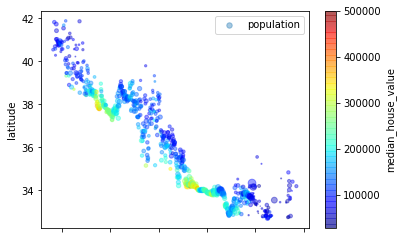

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

data_group_long.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                    s=data_group_long["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)              
plt.legend()